In [2]:
import numpy as np
import math
from math import comb
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
from typing import List, Tuple

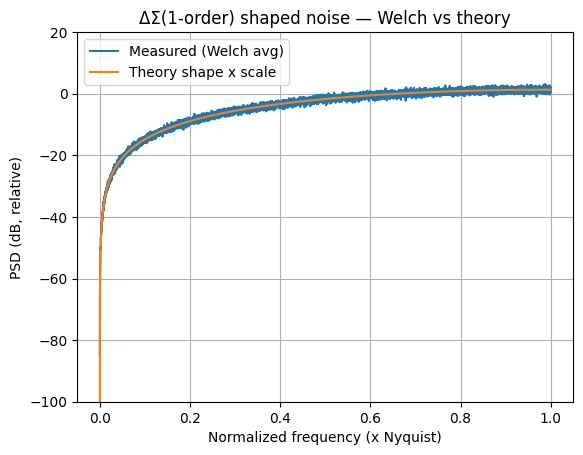

HF/LF mean power ratio ≈ 34.9 dB 


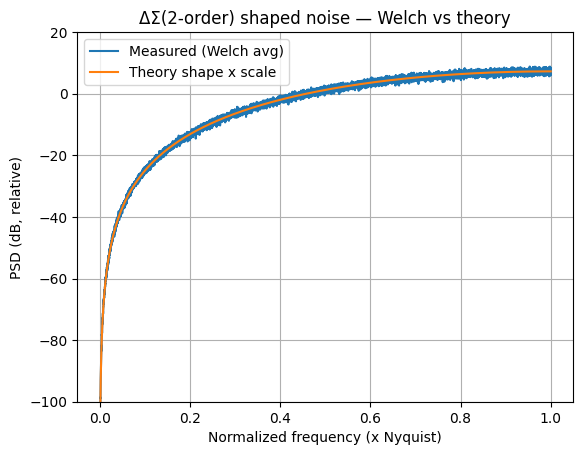

HF/LF mean power ratio ≈ 67.3 dB 


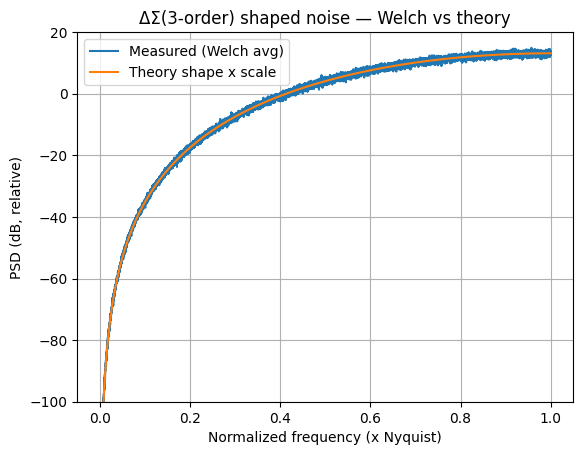

HF/LF mean power ratio ≈ 98.6 dB 


In [3]:
# N阶delta-sigma adc噪声
# ---------- 工具：NTF(z) 的 FIR 系数 (1 - z^-1)^order ----------
def ntf_fir(order: int) -> np.ndarray:
    assert order >= 1
    # b[k] = (-1)^k * C(order, k), k=0..order
    return np.array([((-1)**k) * comb(order, k) for k in range(order + 1)], dtype=np.float64)

# ---------- 通用阶数：ΔΣ 噪声序列 ----------
def ds_noise_time_series(N: int, delta: float = 2.0, order: int = 2,
                         rng: np.random.Generator = None) -> np.ndarray:
    """
    生成满足 S_e(ω) = (Δ^2/12) |(1 - e^{-jω})^order|^2 的塑形噪声时域序列
    """
    if rng is None:
        rng = np.random.default_rng()
    # 量化白噪：U(-Δ/2, +Δ/2)，方差 Δ^2/12
    u = rng.uniform(low=-delta/2, high=delta/2, size=N).astype(np.float64)
    b = ntf_fir(order)  # [1, -order, ..., (-1)^order]
    # 用卷积实现 NTF：e = u * b
    e = np.convolve(u, b, mode='full')[:N]
    return e

# ---------- 通用阶数：理论带内噪声 ----------
def theory_inband_noise(delta: float, osr: int, order: int) -> float:
    """
    砖墙低通(0~π/OSR)下的理论带内噪声功率：
    (Δ^2/12) * π^(2L) / (2L+1) * OSR^-(2L+1),  L=order
    """
    L = order
    return (delta**2 / 12.0) * (np.pi**(2*L)) / (2*L + 1) * (osr ** (-(2*L + 1)))

# ---------- Welch PSD ----------
def welch_psd(x, nperseg=16384, noverlap=8192):
    step = nperseg - noverlap
    w = np.hanning(nperseg)
    U = np.sum(w**2)
    acc = None
    K = 0
    for i in range(0, len(x)-nperseg+1, step):
        seg = x[i:i+nperseg] * w
        E = np.fft.rfft(seg)
        P = (np.abs(E)**2) / U
        acc = P if acc is None else acc + P
        K += 1
    psd = acc / K
    w = np.linspace(0.0, np.pi, len(psd))  # 数字角频率
    f_n = w / np.pi
    return f_n, psd

# ---------- 通用阶数：校准到理论带内功率 ----------
def calibrate_noise_gain_to_theory(y_noise: np.ndarray, osr: int, delta: float = 2.0,
                                   order: int = 2, nperseg=16384, noverlap=8192) -> np.ndarray:
    """
    用 Welch PSD 估算 0..π/OSR 的带内功率，并缩放到理论值。
    仅用于“幅度对齐”，形状比较不受影响。
    """
    f_n, psd = welch_psd(y_noise, nperseg=nperseg, noverlap=noverlap)
    # 归一化到 Nyquist=1，则带内上限在 f_n <= 1/OSR
    k_cut = int(np.floor(len(f_n) / osr))
    if k_cut < 1:
        return y_noise
    # 简单离散积分（等间隔频点）：功率 ~ sum(PSD) * Δf，Δf = 1/(len(f_n)-1)（对 f_n）
    df = 1.0 / (len(f_n) - 1)
    meas_inband_power = float(np.sum(psd[:k_cut+1]) * df)
    target = theory_inband_noise(delta, osr, order)
    if meas_inband_power <= 0 or target <= 0:
        return y_noise
    scale = np.sqrt(target / meas_inband_power)
    return y_noise * scale

# ---------- 入口：生成 ADC 噪声（可选阶数） ----------
def generate_adc_noise(N: int, delta: float = 2.0, osr=32, order: int = 2,
                       rng: np.random.Generator = None):
    y = ds_noise_time_series(N=N, delta=delta, order=order, rng=rng)
    y = calibrate_noise_gain_to_theory(y, osr=osr, delta=delta, order=order)
    return y

# ---------- 画幅频响应（可选阶数） ----------
def plot_noise_amp_freq_response(e, delta=2.0, order=2, title_prefix="ΔΣ"):
    f_n, psd_avg = welch_psd(e, nperseg=1<<15, noverlap=1<<14)
    w = f_n * np.pi

    # 理论形状： (Δ^2/12) * (2 sin(w/2))^(2*order)
    psd_th = (delta**2 / 12.0) * (2.0*np.sin(w/2.0))**(2*order)
    # 在高频处做形状匹配（均值对齐）
    hf = slice(int(0.90*len(psd_avg)), len(psd_avg))
    scale = (psd_avg[hf].mean() / psd_th[hf].mean()) if psd_th[hf].mean() > 0 else 1.0
    psd_th_scaled = psd_th * scale

    # 作图
    plt.figure()
    plt.ylim(-100, 20)
    plt.plot(f_n, 10*np.log10(psd_avg + 1e-300), label="Measured (Welch avg)")
    plt.plot(f_n, 10*np.log10(psd_th_scaled + 1e-300), label="Theory shape x scale")
    plt.xlabel("Normalized frequency (x Nyquist)")
    plt.ylabel("PSD (dB, relative)")
    plt.title(f"{title_prefix}({order}-order) shaped noise — Welch vs theory")
    plt.legend(); plt.grid(True); plt.show()

    # 高频/低频均值比（避免用最大值）
    lf = slice(1, max(16, int(0.02*len(psd_avg))))
    hf = slice(int(0.98*len(psd_avg)), len(psd_avg))
    ratio_db = 10*np.log10(psd_avg[hf].mean() / psd_avg[lf].mean())
    print(f"HF/LF mean power ratio ≈ {ratio_db:.1f} dB ")


# 生成adc的噪声测试
N     = 1 << 20
delta = 2.0
OSR   = 32
rng   = np.random.default_rng(0)

# 一阶
e1 = generate_adc_noise(N, delta, OSR, order=1, rng=rng)
plot_noise_amp_freq_response(e1, delta=delta, order=1, title_prefix="ΔΣ")

# 二阶
e2 = generate_adc_noise(N, delta, OSR, order=2, rng=rng)
plot_noise_amp_freq_response(e2, delta=delta, order=2, title_prefix="ΔΣ")

# 三阶
e3 = generate_adc_noise(N, delta, OSR, order=3, rng=rng)
plot_noise_amp_freq_response(e3, delta=delta, order=3, title_prefix="ΔΣ")